In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Clustering

In [3]:
def create_cluster(data):
    wcss=[]
    for i in range(1,11):
        kmeans=KMeans(n_clusters=i, init='k-means++',random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    if not os.path.isdir('preprocessing_data'):
        os.mkdir('preprocessing_data')
    plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig('preprocessing_data/K-Means_Elbow.PNG') 
    
    kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')
    total_clusters=kn.knee
    kmeans_final=KMeans(n_clusters=total_clusters, init='k-means++',random_state=50)
    clusters=kmeans_final.fit_predict(data)
    data['Cluster']=clusters
    
    if not os.path.isdir('Clustering'):
        os.mkdir('Clustering')
    pickle.dump(kmeans_final, open('Clustering/cluster.pickle', 'wb'))
    return data

## Training Pipeline

In [4]:
def train_preprocessing_pipeline(x_train, y_train):
    data=pd.concat([x_train, y_train], axis=1)
    data=data.reset_index(drop=True)
    
    # dropping unnecessary columns
    data=data.drop(columns=['Item_Type','Item_Weight','Outlet_Identifier'],axis=1)
    
    # imputing missing values
    data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].median()], inplace=True)
                
    outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
    miss_bool = data['Outlet_Size'].isnull()
    data.loc[miss_bool, 'Outlet_Size'] = data.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
    
    # editing dataset
    data['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)
    
    data['Item_Identifier']=data['Item_Identifier'].apply(lambda x : x[:2])
    data.loc[data['Item_Identifier']=="NC",'Item_Fat_Content']='Non Edible'
    
    data['Outlet_Age']=2013-data['Outlet_Establishment_Year']
    data=data.drop(columns=['Outlet_Establishment_Year'])
    
    #encoding categorical values
    data['Outlet_Size']=data['Outlet_Size'].map({'Small':0, 'Medium': 1, 'High': 2})
    
    onehot_col=['Item_Identifier', 'Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']
    
    onehot_enc=OneHotEncoder(drop="first", sparse=False)
    enc_array=onehot_enc.fit_transform(data[onehot_col])
    enc_df=pd.DataFrame(enc_array)
    data=data.drop(columns=onehot_col)
    data=pd.concat([data, enc_df], axis=1)
    if not os.path.isdir('Encoding'):
        os.mkdir('Encoding')
    pickle.dump(onehot_enc, open('Encoding/encoder.pickle', 'wb'))
                
    #scaling numerical values
    data['Item_Outlet_Sales']=np.log(data['Item_Outlet_Sales'])
    
    num_cols=['Item_Visibility', 'Item_MRP', 'Outlet_Age']
    num_df=data[num_cols]
    cat_output_df=data.drop(columns=num_cols) #categorical and output columns
    scaler=StandardScaler()
    num_array=scaler.fit_transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    if not os.path.isdir('Scaling'):
        os.mkdir('Scaling')
    pickle.dump(scaler, open('Scaling/scaler.pickle', 'wb'))
    data=pd.concat([num_df, cat_output_df], axis=1)
    
    #clustering
    x=data.drop(columns=['Item_Outlet_Sales'])
    y=data['Item_Outlet_Sales']
    x=create_cluster(x)
    data=pd.concat([x,y], axis=1)
    return data

## Testing Pipeline

In [5]:
def test_preprocessing_pipeline(x_train, y_train):
    data=pd.concat([x_train, y_train], axis=1)
    data=data.reset_index(drop=True)
    
    # dropping unnecessary columns
    data=data.drop(columns=['Item_Type','Item_Weight','Outlet_Identifier'],axis=1)
    
    # imputing missing values
    data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].median()], inplace=True)
                
    outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
    miss_bool = data['Outlet_Size'].isnull()
    data.loc[miss_bool, 'Outlet_Size'] = data.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
    
    # editing dataset
    data['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)
    data['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)
    
    data['Item_Identifier']=data['Item_Identifier'].apply(lambda x : x[:2])
    data.loc[data['Item_Identifier']=="NC",'Item_Fat_Content']='Non Edible'
    
    data['Outlet_Age']=2013-data['Outlet_Establishment_Year']
    data=data.drop(columns=['Outlet_Establishment_Year'])
    
    #encoding categorical values
    data['Outlet_Size']=data['Outlet_Size'].map({'Small':0, 'Medium': 1, 'High': 2})
    
    onehot_col=['Item_Identifier', 'Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']
    onehot_enc=pickle.load(open('Encoding/encoder.pickle', 'rb'))
    enc_array=onehot_enc.transform(data[onehot_col])
    enc_df=pd.DataFrame(enc_array)
    data=data.drop(columns=onehot_col)
    data=pd.concat([data, enc_df], axis=1)
                   
    #scaling numerical values
    data['Item_Outlet_Sales']=np.log(data['Item_Outlet_Sales'])
    
    num_cols=['Item_Visibility', 'Item_MRP', 'Outlet_Age']
    num_df=data[num_cols]
    cat_output_df=data.drop(columns=num_cols) #categorical and output columns
    scaler=pickle.load(open('Scaling/scaler.pickle', 'rb'))
    num_array=scaler.transform(num_df)
    num_df=pd.DataFrame(num_array, columns=num_df.columns)
    data=pd.concat([num_df, cat_output_df], axis=1)
    
    #clustering
    x=data.drop(columns=['Item_Outlet_Sales'])
    y=data['Item_Outlet_Sales']
    kmeans=pickle.load(open('Clustering/cluster.pickle', 'rb'))
    clusters=kmeans.predict(x)
    x['Cluster']=clusters
    data=pd.concat([x,y], axis=1)
    return data

In [6]:
train=pd.read_csv('Train.csv')
x=train.drop(columns=['Item_Outlet_Sales'])
y=train['Item_Outlet_Sales']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

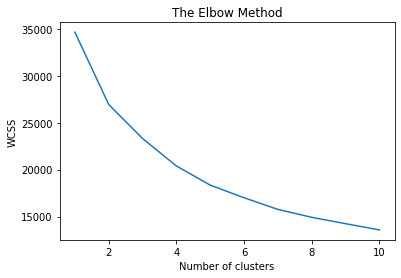

In [7]:
train_df=train_preprocessing_pipeline(x_train, y_train)
test_df=test_preprocessing_pipeline(x_test, y_test)

In [8]:
train_df.head()

,Item_Visibility,Item_MRP,Outlet_Age,Outlet_Size,0,1,2,3,4,5,6,7,8,Cluster,Item_Outlet_Sales
0,-0.311173,0.056844,-0.742659,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3,7.621363
1,0.194077,-0.511771,-1.102075,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,7.858884
2,-0.813760,0.091624,-0.503049,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,3,6.764891
3,-0.503697,-1.321826,1.294031,2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,6.384456
4,-0.661740,1.216063,1.533642,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5.386248


In [9]:
test_df.head()

,Item_Visibility,Item_MRP,Outlet_Age,Outlet_Size,0,1,2,3,4,5,6,7,8,Cluster,Item_Outlet_Sales
0,2.079976,0.687464,1.294031,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2,8.395305
1,-0.696120,1.854745,-1.102075,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3,8.485708
2,-0.528476,0.837563,1.533642,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,7.737623
3,-0.347227,-0.521901,-1.102075,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0,6.970993
4,-0.515677,0.636221,0.095978,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3,7.760302


In [10]:
train_df['Cluster'].unique()

array([3, 0, 1, 2])

In [22]:
def get_best_param_rf(x_train, y_train, x_test, y_test):
    best_params={}

    param1={'criterion': ['mse','mae']}
    param2={'max_depth' : range(3,10,1)}
    param3={'max_features' : [i/100.0 for i in range(70,100,3)]}
    param4={'max_samples' : [i/100.0 for i in range(70,100,5)]}
    param5={'n_estimators':range(10,100,5)}

    parameters=[param1, param2, param3, param4, param5]

    for param in parameters:
        grid=GridSearchCV(RandomForestRegressor(), param, cv=5, n_jobs=-1)
        grid.fit(x_train, y_train)
        best_params.update(grid.best_params_)

    criterion=best_params['criterion']
    max_depth=best_params['max_depth']
    max_features=best_params['max_features']
    max_samples=best_params['max_samples']
    n_estimators=best_params['n_estimators']

    model=RandomForestRegressor(criterion=criterion, max_depth = max_depth, max_features = max_features, max_samples = max_samples, n_estimators = n_estimators)
    model.fit(x_train, y_train)
    y_pred=model.predict(x_test)

    r2=r2_score(y_test, y_pred)
    return model, r2

In [23]:
clusters=np.sort(train_df['Cluster'].unique())

for i in clusters:
    train=train_df[train_df['Cluster']==i]
    test=test_df[test_df['Cluster']==i]


    train_x=train.drop(columns=['Item_Outlet_Sales', 'Cluster'])
    train_y=train['Item_Outlet_Sales']

    test_x=test.drop(columns=['Item_Outlet_Sales', 'Cluster'])
    test_y=test['Item_Outlet_Sales']
    
    model_rf, r2_rf = get_best_param_rf(train_x, train_y, test_x, test_y)

    print(f'Cluster : {i}  r2_rf = {r2_rf}')

    if not os.path.isdir('Models'):
        os.mkdir('Models')
    pickle.dump(model_rf, open(r'Models/'RF'+{str(i)}.pickle', 'wb'))

Cluster : 0  r2_rf = 0.5403053127423622
Cluster : 1  r2_rf = 0.7712960216578946
Cluster : 2  r2_rf = 0.7862613303826015
Cluster : 3  r2_rf = 0.4134692448304762
